In [276]:
import pandas as pd
import numpy as np
import matplotlib as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import norm

In [263]:
DATA = pd.read_excel('DATA.xlsx').rename(columns = {'Unnamed: 0' : "Time"})
data = DATA

In [264]:
country = 'US'

nchoice = 2
#(1) n: employment
#(2) n: hours

nint = 1
#(1) n=I(1)
#(0) n=I(0)

difn = 'yes'
#'yes' computed correlations based on employment growth
#'no' computed correlations based on detrended employment

LAGS=4
NVAR=2
NSTEP= 100
NDRAWS= 500
NSE = 2
IRH = 13
NW = 6


In [265]:
if nchoice==1: labor = 'LHEM' #'employment'
elif nchoice==2: labor = 'LPMHU' #'hours'
gdp = 'GDPQ'
labor_series = data[labor]

In [266]:
print("country")
print('n: \t {labor} I({nint})')

yx = DATA[gdp]
nber = DATA.NBER #Manually entered recession start and end times according to nber
nberg = DATA.NBERG

nx = DATA[labor]

nobs = len(yx)

country
n: 	 {labor} I({nint})


In [267]:
## AR test stuff
xx = yx/nx
xx[0:4] = np.nan
xx.head(10)

0          NaN
1          NaN
2          NaN
3          NaN
4    13.765500
5    13.913806
6    13.859401
7    14.067610
8    14.211214
9    14.404248
dtype: float64

# What

In [268]:
data['dlabor'] = np.log(data[labor]) - np.log(data[labor].shift(1))
data['n'] = 100 + np.log(data[labor]/data[labor][4]) * 100
data['n'][0:4] = np.nan
data['dn'] = data['dlabor']*100
data['dn'][0:5] = np.nan

data['dgdp'] = np.log(data[gdp]) - np.log(data[gdp].shift(1))
data['y'] = 100 + np.log(data[gdp]/data[gdp][4]) * 100
data['y'][0:4] = np.nan
data['dy'] = data['dgdp']*100
data['dy'][0:5] = np.nan

data['xx'] = data[gdp].div(data[labor])
data['x'] = 100 + np.log(data['xx']/data['xx'][4]) * 100
data['x'][0:4] = np.nan
data['dx'] = (np.log(data['xx']) - np.log(data['xx'].shift(1)))*100
data['dx'][0:5] = np.nan

C:\Users\joshu\AppData\Local\Temp\ipykernel_23144\2407165987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['n'][0:4] = np.nan
C:\Users\joshu\AppData\Local\Temp\ipykernel_23144\2407165987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dn'][0:5] = np.nan
C:\Users\joshu\AppData\Local\Temp\ipykernel_23144\2407165987.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y'][0:4] = np.nan
C:\Users\joshu\AppData\Loca

In [269]:
## Correlation coefficeint
np.corrcoef(data.dx.dropna(),data.dn.dropna())[0,1]

-0.2576565306027087

In [270]:
# Compute means
dx = data.dx.dropna()
dn = data.dn.dropna()

dx_mean = np.mean(dx)
dn_mean = np.mean(dn)

# Compute deviations
dxdn = (dx - dx_mean) * (dn - dn_mean)
########################
def autocovariance(x, lag):
    if lag == 0:
        return np.var(x, ddof=1)  # ddof=1 for sample variance
    else:
        return np.cov(x[:-lag], x[lag:])[0, 1]

# Maximum number of lags (NW in the RATS code)
NW = 6  # You can adjust this

# Compute autocovariances with Bartlett kernel
sacdxdn = autocovariance(dxdn.reset_index(drop=True), 0)  # Autocovariance at lag 0

for i in range(1, NW):
    weight = 2.0 * (1.0 - (i / (NW + 1.0)))
    sacdxdn += weight * autocovariance(dxdn, i)
    
# Variances of dx and dn
dx_var = np.var(dx)
dn_var = np.var(dn)

# Number of observations
nobs = len(dxdn)

# Compute the standard error
sdcdxdn = np.sqrt(sacdxdn / nobs) / np.sqrt(dx_var * dn_var)

# Assuming the correlation coefficient is stored in cdxdn
corr_coef = np.corrcoef(dx, dn)[0, 1]

# Compute p-value
p_value = 2.0 * (1.0 - norm.cdf(abs(corr_coef) / sdcdxdn))

print("Standard Error for correlation:", sdcdxdn)
print("P-value:", p_value)

HP filter

In [272]:
# Apply HP filter to GDP and labor data
y_cycle, y_trend = hpfilter(data.y.dropna(), lamb=1600)
n_cycle, n_trend = hpfilter(data.n.dropna(), lamb=1600)
x_cycle, x_trend = hpfilter(data.x.dropna(), lamb=1600)

In [273]:
np.corrcoef(x_cycle,n_cycle)[0,1]

-0.2915678957131867

# Conditional Corr

c:\Users\joshu\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 18, Sep, 2024
Time:                     20:58:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -19.5863
Nobs:                     187.000    HQIC:                  -19.7713
Log likelihood:           1347.71    FPE:                2.28448e-09
AIC:                     -19.8973    Det(Omega_mle):     2.07949e-09
--------------------------------------------------------------------
Results for equation dgdp
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.004646         0.001082            4.294           0.000
L1.dgdp           0.202463         0.097388            2.079           0.038
L1.dlabor         0.403506         0.123535            3.266           0.001


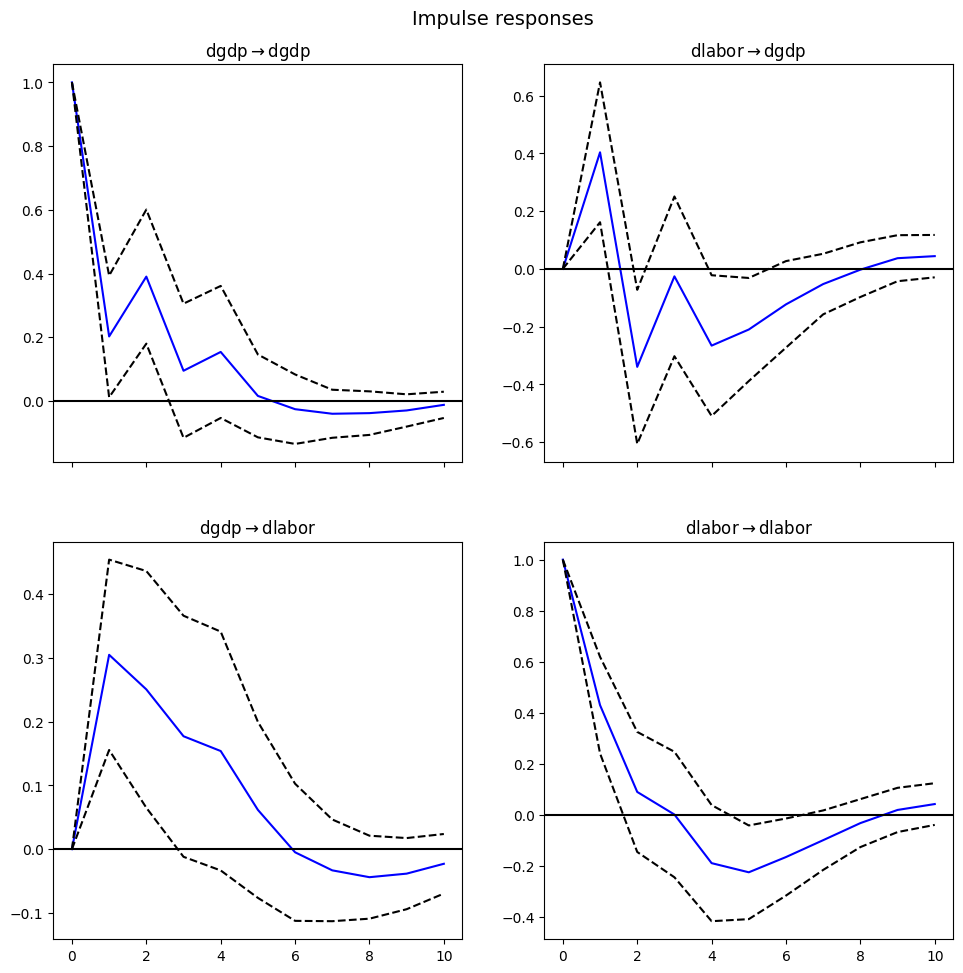

In [290]:
# Assuming you have already set up the data for GDP (dgdp) and labor (dlabor)
var_data = data[['dgdp', 'dlabor']].dropna()

# Fit the VAR model
model = VAR(var_data)
results = model.fit(maxlags=4)  # You can adjust lags based on the original RATS code

# Summary of the results
print(results.summary())


#Calculate Impulse Response Functions (IRFs)----------------------
# Calculate impulse responses
nsteps = 10  # Number of steps to compute the IRFs
irf = results.irf(nsteps)

# Plot the IRF for each variable
irf.plot(orth=False)

# Get the raw IRF values (impulse responses)
imp = irf.irfs  # This returns a 3D array (steps, variables, shocks)

#Assign IRF Results to Variables (c11, c21z, etc.)----------------------
# Technology shock responses
c11 = imp[:, 0, 0]  # Response of GDP to technology shock
c21z = imp[:, 1, 0]  # Response of employment to technology shock

# Non-technology (demand) shock responses
c12 = imp[:, 0, 1]  # Response of GDP to non-tech shock
c22z = imp[:, 1, 1]  # Response of employment to non-tech shock

# Compute total response by adding different effects
c31 = c11 + c21z  # Total effect on output for technology shock
c32 = c12 + c22z  # Total effect on output for non-technology shock

#Assign Responses to dyt, dnt, dxt, dyd, dnd, dxd ------------
# Dynamic responses to technology shock
dyt = c31  # Response of output to technology shock
dnt = c21z  # Response of employment to technology shock
dxt = c11  # Response of productivity to technology shock

# Dynamic responses to non-technology shock
dyd = c32  # Response of output to non-tech shock
dnd = c22z  # Response of employment to non-tech shock
dxd = c12  # Response of productivity to non-tech shock


In [291]:
dyt

array([ 1.        ,  0.50737376,  0.64091752,  0.27194606,  0.30778505,
        0.07742586, -0.0307547 , -0.07344286, -0.0822216 , -0.06820912,
       -0.03515858])

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(dyt, label='Output response to technology shock')
plt.plot(dnt, label='Employment response to technology shock')
plt.plot(dxt, label='Productivity response to technology shock')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(dyd, label='Output response to non-tech shock')
plt.plot(dnd, label='Employment response to non-tech shock')
plt.plot(dxd, label='Productivity response to non-tech shock')
plt.legend()
plt.show()

TypeError: 'module' object is not callable

# -----------------------------

c:\Users\joshu\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 18, Sep, 2024
Time:                     19:50:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -19.5863
Nobs:                     187.000    HQIC:                  -19.7713
Log likelihood:           1347.71    FPE:                2.28448e-09
AIC:                     -19.8973    Det(Omega_mle):     2.07949e-09
--------------------------------------------------------------------
Results for equation dgdp
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.004646         0.001082            4.294           0.000
L1.dgdp           0.202463         0.097388            2.079           0.038
L1.dlabor         0.403506         0.123535            3.266           0.001


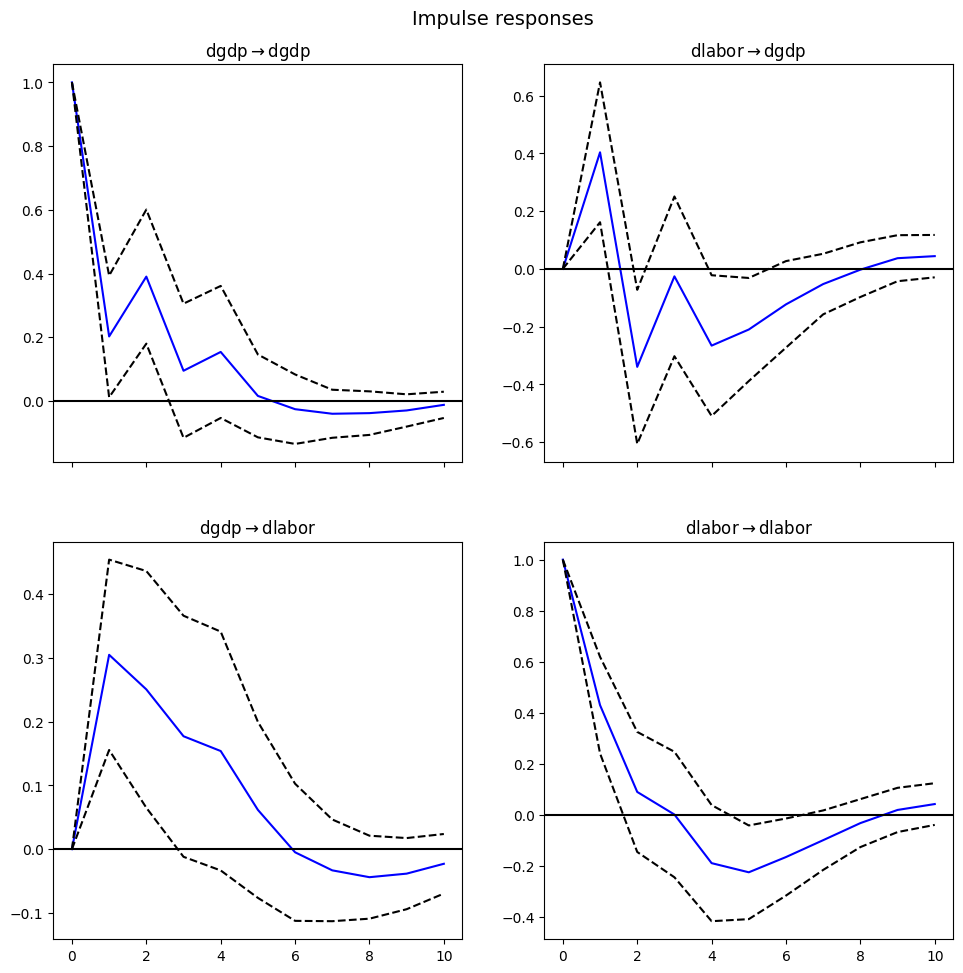

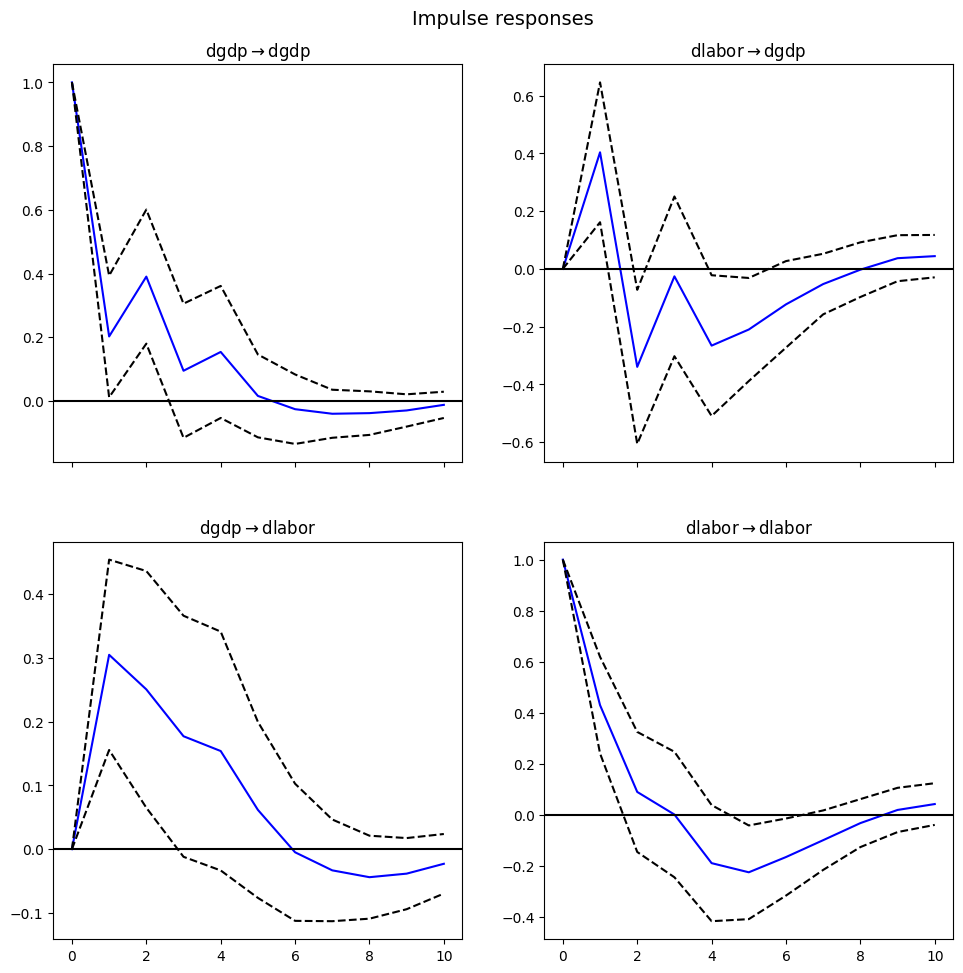

In [274]:
# Create VAR model with GDP and labor variables
var_data = DATA[['dgdp', 'dlabor']].dropna()
model = VAR(var_data)
results = model.fit(maxlags=4)

# Print results summary
print(results.summary())

# Impulse response
irf = results.irf(10)
irf.plot()